In [1]:
from rs_graph.data import (
    load_extended_paper_details_dataset,
    load_basic_repos_dataset,
)
import numpy as np

np.random.seed(42)

repos = load_basic_repos_dataset()
papers = load_extended_paper_details_dataset().dropna(subset=["embedding"]).sample(100)

# Get repo name from repos dataset and merge with papers on doi
papers = papers.merge(repos[["repo", "doi"]], on="doi")

# Format into ready for training
papers = papers.drop(columns=["url", "authors", "citation_count"])
papers["paper_embedding"] = papers["embedding"].apply(lambda x: np.array(x["vector"]))
papers = papers.drop(columns=["embedding"])

# Drop duplicates
papers = papers.drop_duplicates(subset=["doi"])
papers.sample(3)

,corpus_id,doi,title,repo,paper_embedding
25,246256940,10.21105/joss.03937,WaveletsExt.jl: Extending the boundaries of wa...,https://github.com/UCD4IDS/WaveletsExt.jl,"[-0.4476344883441925, -4.597569465637207, 0.59..."
51,250101337,10.21105/joss.04354,mixComp: An R package for estimating complexit...,https://github.com/yuliadm/mixComp,"[-6.583120822906494, -0.7380831241607666, -1.1..."
4,132046403,10.21105/joss.01336,rrcf: Implementation of the Robust Random Cut ...,https://github.com/kLabUM/rrcf,"[-0.7245601415634155, -4.046160697937012, -0.6..."


In [2]:
# for each repo, get the reademe (if it exists) and the description.
from dotenv import load_dotenv
from ghapi.all import GhApi
from rs_graph.data.enrichment.github import get_repo_parts_from_url
import base64

load_dotenv()

api = GhApi()

def get_repo_readme(repo: str) -> str | None:
    repo_parts = get_repo_parts_from_url(repo)
    try:
        b64_encoded_readme = api.repos.get_readme(
                owner=repo_parts.owner,
                repo=repo_parts.repo,
            )["content"]
        
        return base64.b64decode(b64_encoded_readme).decode("utf-8")
    except:
        return None

In [3]:
# Get the READMEs and then then embeddings for each README
from tqdm import tqdm
import time

readmes = []
for repo in tqdm(papers["repo"], total=len(papers)):
    readmes.append(get_repo_readme(repo))
    time.sleep(0.75)

# Attach to papers
papers["readme"] = readmes

# Drop nulls
papers = papers.dropna(subset=["readme"])
papers.shape

100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


In [9]:
# Get the embeddings for each README
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")

readme_embeddings = model.encode(papers["readme"].tolist())
readme_embeddings.shape

(88, 768)

In [10]:
# Attach back to dataframe
papers["readme_embedding"] = [np.array(vec) for vec in readme_embeddings.tolist()]
papers.sample(3)

,corpus_id,doi,title,repo,paper_embedding,readme,readme_embedding
43,248395984,10.21105/joss.03061,TUM Open Infra Platform: an open source packag...,https://github.com/tumcms/Open-Infra-Platform,"[-1.6109504699707031, -0.9783458709716797, 0.1...",# TUM Open Infra Platform\r\n\r\n[![status](ht...,"[-0.049009770154953, -0.00370903336443007, -0...."
83,245019698,10.21105/joss.03376,"samplics: a Python Package for selecting, weig...",https://github.com/survey-methods/samplics/,"[-5.411468505859375, -4.241408824920654, -3.25...","<img src=""./img/samplics_logo.jpg"" align=""lef...","[0.004012211691588163, 0.020429059863090515, -..."
60,231709743,10.21105/joss.03000,PyFstat: a Python package for continuous gravi...,https://github.com/PyFstat/PyFstat/,"[-4.459370136260986, -3.194636821746826, -0.34...",# PyFstat\n\nThis is a python package providin...,"[-0.015314193442463875, 0.025154467672109604, ..."


In [23]:
import pandas as pd

# Mark all current columns as label = match
papers["label"] = "match"

# Construct negative random samples
negative_samples = []
for _, row in tqdm(papers.iterrows(), total=len(papers)):
    # this row will be the paper
    # draw three other random rows and use the repo information
    # from them as the negative
    for _ in range(5):
        other_row = papers.sample(1).iloc[0]

        # resample if the repo is the same
        while other_row["repo"] == row["repo"]:
            other_row = papers.sample(1).iloc[0]
        
        # Append the negative example row
        negative_samples.append(
            {
                "corpus_id": row.corpus_id,
                "doi": row.doi,
                "title": row.title,
                "paper_embedding": row.paper_embedding,
                "repo": other_row.repo,
                "readme": other_row.readme,
                "readme_embedding": other_row.readme_embedding,
                "label": "no_match",
            }
        )

# Construct the negative samples dataframe
negative_samples = pd.DataFrame(negative_samples)

# Combine the two dataframes
papers = pd.concat([papers, negative_samples])
papers.sample(3)

100%|██████████| 352/352 [00:00<00:00, 746.68it/s]


,corpus_id,doi,title,repo,paper_embedding,readme,readme_embedding,label,interaction_embedding
572,249687575,10.21105/joss.03330,spopt: a python package for solving spatial op...,https://github.com/ElsevierSoftwareX/SOFTX-D-1...,"[-2.466102123260498, -5.326638698577881, 2.033...",Prerequisites to use software are as follows:\...,"[-0.027840083464980125, -0.09813134372234344, ...",no_match,NaN
1505,236881648,10.21105/joss.03783,The Python Sky Model 3 software,https://github.com/snek5000/snek5000,"[-2.4996628761291504, -3.1628201007843018, 1.3...","<div align=""center"">\n\n# Snek5000\n\n[![PyPI]...","[0.0036033685319125652, -0.030192838981747627,...",no_match,NaN
50,240523569,10.21105/joss.03661,infer: An R package for tidyverse-friendly sta...,https://github.com/PathwayCommons/grounding-se...,"[-4.821259021759033, -3.738215446472168, 2.148...",# grounding-search\n\n[![DOI](https://zenodo.o...,"[0.035813700407743454, -0.013034834526479244, ...",match,"[-0.1726671261934083, 0.04872701976909344, -0...."


In [24]:
# Save the dataset
papers.to_parquet("temp-repo-paper-dataset.parquet")

In [25]:
# Create interaction embeddings and train logistic regression CV
papers["interaction_embedding"] = papers.apply(
    lambda row: row.paper_embedding * row.readme_embedding,
    axis=1,
)

Precision: 0.10869565217391304
Recall: 0.14084507042253522
F1: 0.12269938650306747


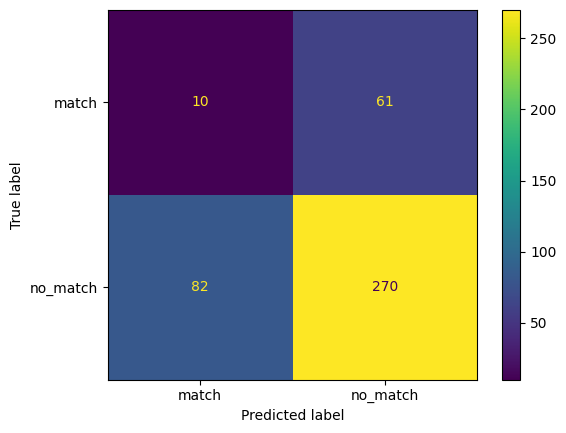

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    papers["interaction_embedding"].tolist(),
    papers["label"].tolist(),
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=papers["label"].tolist(),
)

# Train model
clf = LogisticRegressionCV(
    cv=10,
    max_iter=1000,
    random_state=42,
    class_weight="balanced",
).fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", pos_label="match")

# Print results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)